# Monte Carlo-simuleringer av polymerfolding

Dato: 05.02.2024

I dette prosjektet har vi analysert polymerers egenskaper ved hjelp av numerikk. En polymer er satt sammen av flere repeterende enheter, monomerer. Vi har laget et program der vi kan generere polymerer av ulik lengde og pseudotilfeldig simulere rotasjoner. Til de stokastiske simuleringene har vi brukt Monte Carlo metoden. Videre har vi sett på hvordan antall rotasjoner, temperatur og styrke på vekselvirkninger påvirker polymerene sin energi og struktur.

Koden i dette prosjektet inneholder mange større beregninger, noe som betyr at kjøretiden kan bli lang. Vi har derfor importert jit og njit fra numba for å kunne kompilere koden og dermed minimere kjøretiden ('A ~5 minute guide to Numba'). I tillegg har vi kun brukt numpy arrays, i stedet for vanlige python lister, da beregninger med numpy er mye raskere.

In [155]:
%config InlineBackend.figure_formats = ['svg'] # Makes the plots svg (visually better)

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit # Njit: No-Python mode, JIT (Just-In-Time compilation)
from tqdm.auto import tqdm, trange # Imported to use progress bars while running code
import time

#### Representasjon av polymerene
Vi har valgt å representere hvert polymer som et Nx2 array. Polymeren er satt sammen av flere monomerer, der hvert element i polymer-arrayet er en monomer. Vi vil sentrere polymeren på midten av koordinatsystemet for at det skal ha et bedre utgangspunkt når det skal roteres. Seinere bruker vi koordinaten til elementene i polymer-arrayet til å representere polymeren og monomerene i et kartesisk koordinatsystem.

Det er også mulig å representere et polymer av lengden N i et array av dimensjon M x M, der M => N. De resterende plassene i M x M arrayet, som ikke illustrer en monomer, ville vært representert av nullere. Dette ville vært overflødig data som vil gjøre at kjøretiden blir betydelig lenger.

In [157]:
N = 7  # Lenght of polymer
M = 9  # Gitterdimension

@njit
def init_polymer(N):
    polymer = np.zeros((N, 2), dtype=np.int32) # Define the polymer as a Nx2 array with datatype 32 bit
    polymer[:, 1] = np.arange(N)
    polymer[:, 0] = M // 2
    return polymer

init_polymer(N)

array([[4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4],
       [4, 5],
       [4, 6]], dtype=int32)

#### Endemonomerer
Senere skal en polymer roteres tilfeldig rundt et monomer. Vi har valgt å alltid rotere den korteste delen av polymeren. Dersom en polymer blir forsøkt rotert om et endepunkt, vil den dermed ikke roteres og polymeren forblir i ro. Energien bestemmes av formen til polymeren, energien forbli derfor uendretdet under en rotasjon om et endemonomer. Det vil altså hverken oppstå eller forsvinne noen vekselvirkninger mellom monomerer. 
Vi konkluderer med at det ikke vil være hensiksmessig å inkludere endemonomerene i det tilfeldige utvalget monomeren trekkes fra. Vi vil derfor kun trekke fra 1 til N-1 i arrayet når vi skal velge hvilket monomer som skal roteres rundt. Dette minimerer kjøretiden til koden, derav at den slipper å kjøre gjennom unødvendige steg. 

#### Illustrasjon av polymerene
For å illustrere polymerene, plotter vi monomerene som prikker bundet sammen av linjer som illustrer hele polymeren. Hvert monomer har egen farge og eget nummer, dette gjør det enkelt å skille monomerene fra hverandre og bakgrunnen, det viser også tydelig hvilke rekkefølge de er plassert i. Polymeren vi starter med er illustrert som en rett linje, denne er sentrert i midten av det kartesiske koordinatsystemet så det blir enklere å arbeide med senere når det skal roteres. 

Under har vi illustrert en rett polymer av lengde 7.

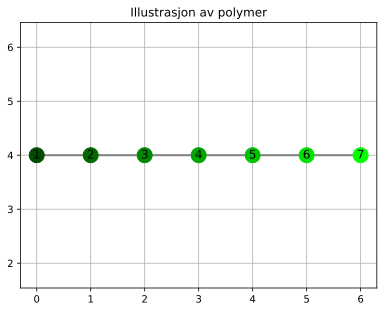

In [158]:
def plot_polymer(polymer):
    
    # Assuming 'polymer' is an Nx2 numpy array
    plt.figure()
    num_points = polymer.shape[0]

    # Generating different shades of green
    greens = np.linspace(0.3, 1, num_points)  # Adjust the range for different shades
    colors = [(0, green, 0, 1) for green in greens]  # RGB tuples with varying green component

    # Plotting the lines first
    plt.plot(polymer[:, 1], polymer[:, 0], 'o-', color='grey', markersize=10, linewidth=2)

    # Plotting each point and its number
    for i in range(num_points):
        
        # Plot each point with a different color
        plt.plot(polymer[i, 1], polymer[i, 0], 'o', color=colors[i], markersize=15)

        # Centering the number on the dot
        plt.text(polymer[i, 1], polymer[i, 0], str(i+1), color='black', fontsize=12, 
                 horizontalalignment='center', verticalalignment='center')

    plt.title('Illustrasjon av polymer')
    plt.axis('equal')
    plt.grid()
    plt.show()
    
plot_polymer(init_polymer(7))


#### Kriterium for polymerer
Vi har tatt utganspunkt i at bindingene mellom monomerene i polymerene ikke skal kunne brytes, det skal heller ikke være mulig at to monomerer ender opp på samme plass. For at dette alltid skal gjelde må vi kjøre polymerene gjennom en funskjon som sjekker om polymeren vi jobber med ikke er et ødelagt polymer. Dette blir viktig senere i programmet da polymerene skal gjentatte ganger roteres tilfeldig, og slutt polymeren skal være en gyldig et polymer.

Vi har tatt utgangspunkt i at polymerene er Nx2-arrays og at monomerene har hver sin koordinat i arrayet. For at polymeren skal være gyldig er det tre viktige kriterier. 

Det første kriteriumet vi må ta hensyn til er at polymeren består av N monomerer. Dette sjekker vi ved å returnere False dersom polymer-arrayet ikke har like mange elementer som lengden av arrayet. 

Det andre kriteriumet er at hvert monomer representeres av et unikt heltall, altså at vi ikke har noen overlappende punkter. Dette sjekker vi ved å se om det er noen identiske elementer i arrayet.

Det tredje kriteriumet er at monomer m skal være nærmeste nabo med monomer m-1 og m+1. Dette sjekker vi ved å se at avstanden mellom disse er 1.

In [159]:
def polymer_check_slow(polymer: np.ndarray, N: int) -> bool:
    # Checks if polymer has correct length
    if len(polymer) != N:
        return False
    
    # Checks if polymer has overlapping points
    for i in range(N):
        for j in range(N):
            if i != j:
                if polymer[i][0] == polymer[j][0] and polymer[i][1] == polymer[j][1]:
                    return False
    
    # Checks if monomer m is nearest neighbour with m-1 and m+1
    for i in range(N):
        if i == 0 or i == N-1:
            if not ((np.abs(polymer[i,0]-polymer[i+(-1 if i else 1),0]) == 1 and np.abs(polymer[i,1]-polymer[i+(-1 if i else 1),1]) == 0) or 
                    (np.abs(polymer[i,1]-polymer[i+(-1 if i else 1),1]) == 1 and np.abs(polymer[i,0]-polymer[i+(-1 if i else 1),0]) == 0)):
                return False
        else:
            if not ((np.abs(polymer[i,0]-polymer[i+1,0]) == 1 and np.abs(polymer[i,1]-polymer[i+1,1]) == 0) or
                    (np.abs(polymer[i,1]-polymer[i+1,1]) == 1 and np.abs(polymer[i,0]-polymer[i+1,0]) == 0) or
                    (np.abs(polymer[i,0]-polymer[i-1,0]) == 1 and np.abs(polymer[i,1]-polymer[i-1,1]) == 0) or
                    (np.abs(polymer[i,1]-polymer[i-1,1]) == 1 and np.abs(polymer[i,0]-polymer[i-1,0]) == 0)):
                return False
    return True


@njit
def polymer_check(polymer: np.ndarray, N: int) -> bool:
    # Checks if polymer has correct length
    if len(polymer) != N:
        return False
    # Checks if polymer has overlapping points
    for i in range(N):
        for j in range(i + 1, N):
            if np.all(polymer[i] == polymer[j]):
                return False
            
    return True


#### Kodehastighet for polymer_check()
I kodeblokken over har vi laget to ulike funksjoner for å sjekke om polymeren er gyldig. Vi lagde først polymer_check_slow(), videre tok vi to ulike grep for å forbedre kjøretiden til koden og endte med en raskere funksjon polymer_check(). 
Vi fant ut at det ikke var nødvendig å sjekke det tredje kriteriumet, da det er umulig at monomer m ikke er nærmeste nabo med monomer m-1 og m+1 etter en rotasjon med twist_polymer(), som er definert lengre nede. Etter én rotasjon vil den korteste enden av polymeren roteres enten med eller mot klokken, ved at vi multipliserer 2xN-arrayet vårt med en rotasjonsmatrise. Dette vil ikke påvirke avstanden mellom monomer m og m+1 eller m-1, vi har dermed konstantert at det er overflødig å sjekke avstanden mellom alle monomerene. Dette argumentet holder for én rotasjon, og siden samme metode brukes hver gang, kan vi ved induksjon fastslå at dette alltid gjelder. I polymer_check() sjekker vi dermed ikke om avstanden mellom monomer m og m+1/m-1 er 1. Dette vil forbedre kjøretiden siden vi kan fjerne en hel løkke fra polymer_check_slow(). I tillegg har vi lagt til @njit som vil kompilere koden slik at den får maksimal hastighet. 

Funksjonen polymer_check_slow() bruker 103 µs ± 4.86 µs, mens funksjonen polymer_check() bruker 5.87 ns ± 196 ns. Vi ser at polymer_check() er betydelig raskere, og vi vil dermed bruke denne videre i programmet vårt. 

In [160]:
# Checking the difference in run time for both polymer-check functions
%timeit polymer_check(init_polymer(7),7)
%timeit polymer_check_slow(init_polymer(7),7)

The slowest run took 4.50 times longer than the fastest. This could mean that an intermediate result is being cached.
6.49 µs ± 5.04 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
102 µs ± 5.71 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Rotasjon av polymerer
For å rotere polymerene tar vi utganspunkt i matrisemultiplikasjon. Vi innfører to matriser, en som roterer arrayet 90 grader med klokken og en som roterer arrayet 90 grader mot klokken. Polymeren roteres om en valgt monomer, altså en koordinat i arrayet. Det er alltid den korteste siden av polymeren som skal roteres om monomeren, dermed må vi sjekke hvilke side som er kortest. Når vi har funnet korteste siden kan vi multiplisere den korte delen av arrayet med rotasjonsmatrisen. Deretter settes den roterte delen av polymeren tilbake og vi ender opp med et rotert polymer. Denne funksjonen tar ikke hensyn til om vi ender opp med ett gyldig polymer. 

Legg merke til at vi har definert int_matmul() som er vår egen matrisemultiplikasjon. I denne bruker vi numpy og vi kompillerer den ved bruk av @njit. Dette har vi gjort for å forbedre kjøretiden til koden enda et hakk da denne er raskere enn den innebygde matrisemultiplikasjonsoperatoren "@" i python (Steele, 2015).

In [161]:
# Defining two matrixes for clockwise and counterclockwise rotation respectively
CW_ROTATION_MATRIX = np.array([[0, -1], [1, 0]], dtype=np.int32) 
CCW_ROTATION_MATRIX = np.array([[0,1], [-1,0]], dtype=np.int32)

# Faster matrix multiplication than using '@'
@njit
def int_matmul(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    out = np.zeros((a.shape[0], b.shape[1]), dtype=np.int32)
    for i in range(a.shape[0]):
        for j in range(b.shape[1]):
            for k in range(a.shape[1]):
                out[i, j] += a[i, k] * b[k, j]
    return out

@njit
def twist_polymer(polymer: np.ndarray, monomer_idx: int, clockwise: bool) -> np.ndarray:
    
    N = len(polymer)

    # Checks which side is shorter
    shorter_side = monomer_idx < N - monomer_idx - 1 # True if shorter side is 0..=monomer_idx-1, False if shorter side is monomer_idx+1..=N-1

    # Slices array to get the smaller side
    if shorter_side:
        shorter_sub_polymer = polymer[:monomer_idx+1]
    else:
        shorter_sub_polymer = polymer[monomer_idx:]

    # Translates the shorter sub-polymer to origin at polymer[monomer_idx]
    center = polymer[monomer_idx]
    centered_sub_polymer = shorter_sub_polymer - center

    # Rotates the shorter sub-polymer by 90 degrees in the correct direction (matrix multiplication with rotation matrix)
    rotation_matrix = CW_ROTATION_MATRIX if clockwise else CCW_ROTATION_MATRIX
    rotated_sub_polymer = int_matmul(centered_sub_polymer, rotation_matrix.T)

    # Translates back to get final sub_polymer position
    twisted_sub_polymer = rotated_sub_polymer + center

    # Combines the two sub-polymers into a new polymer
    if shorter_side:
        twisted_polymer = np.concatenate((twisted_sub_polymer, polymer[monomer_idx+1:]), axis=0)
    else:
        twisted_polymer = np.concatenate((polymer[:monomer_idx], twisted_sub_polymer), axis=0)

    return twisted_polymer
    

#### Gyldige rotasjoner
Vi skal nå sjekke hvor mange gyldige rotasjoner vi får fra tiwst_polymer(). Dette gjøres ved å telle opp antall gyldige rotasjoner, som er implementert i algoritme 1 der variabelen counter teller for oss.

In [162]:
#Algorithm 1
@njit
def random_rotations(polymer: np.ndarray, N_f: int) -> np.ndarray:
    
    N = len(polymer)
    counter = 0 
    current_polymer = polymer
    clockwise_draws = np.random.rand(N_f) < 0.5 # Choose random direction of rotation
    mon_idx_draws = np.random.randint(1, N - 1, size=N_f)  # Choose random monomer, excluding end-monomers
        
    for i in range(N_f):
        clockwise = clockwise_draws[i]
        mon_idx = mon_idx_draws[i]
        twisted_polymer = twist_polymer(polymer=current_polymer, monomer_idx=mon_idx, clockwise=clockwise)
        if polymer_check(twisted_polymer, len(twisted_polymer)):
            counter +=1
            current_polymer = twisted_polymer
                        
    return current_polymer, counter

For mer oversiktlige plots når vi skal plotte to polymerer vedisden av hverandre har vi definert en funksjon som gjør dette for oss. Dette gjør det visuelt enklere å analysere forskjeller mellom polymerer.

In [163]:
def plot_two_polymers(polymer1: np.ndarray, polymer2: np.ndarray, N_f1: int, N_f2: int, title1: str, title2: str):
    # Assuming both 'polymer1' and 'polymer2' are Nx2 numpy arrays

    # Setting up a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Plot polymer1 in the first subplot
    num_points1 = polymer1.shape[0]
    colors = [(0, green, 0, 1) for green in np.linspace(0.3, 1, num_points1)]
    ax1.plot(polymer1[:, 1], polymer1[:, 0], 'o-', color='grey', markersize=10, linewidth=2)
    for i in range(num_points1):
        ax1.plot(polymer1[i, 1], polymer1[i, 0], 'o', color=colors[i], markersize=15)
        ax1.text(polymer1[i, 1], polymer1[i, 0], str(i+1), color='black', fontsize=12, 
                 horizontalalignment='center', verticalalignment='center')

    if title1 == '':
        ax1.set_title(f'Polymer med {N_f1} forsøkte rotasjoner')
    else:
        ax1.set_title(title1)
    
    ax1.axis('equal')
    ax1.grid()

    # Plot polymer2 in the second subplot
    num_points2 = polymer2.shape[0]
    ax2.plot(polymer2[:, 1], polymer2[:, 0], 'o-', color='grey', markersize=10, linewidth=2)
    for i in range(num_points2):
        ax2.plot(polymer2[i, 1], polymer2[i, 0], 'o', color=colors[i], markersize=15)
        ax2.text(polymer2[i, 1], polymer2[i, 0], str(i+1), color='black', fontsize=12, 
                 horizontalalignment='center', verticalalignment='center')

    if title2 == '':
        ax2.set_title(f'Polymer med {N_f2} forsøkte rotasjoner')
    else:
        ax2.set_title(title2)

    ax2.axis('equal')
    ax2.grid()

    plt.show()

Her er det plottet to polymerer som er forsøkt rotert 4 og 1000 ganger. Det vi ser er at polymeren som er forsøkt rotert 1000 ganger har flere foldninger enn polymeren som er forsøkt rotert 4 ganger.

Polymer forsøkes rotert 4 ganger med 3 gyldige rotasjoner.
Polymer forsøkes rotert 1000 ganger med 594 gyldige rotasjoner.


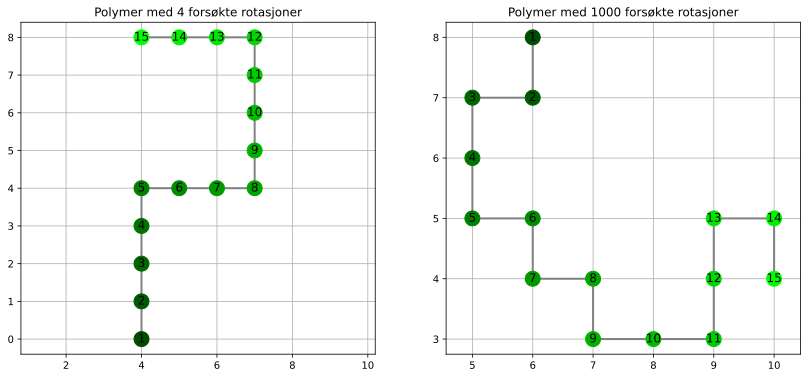

In [164]:
polymer4, valid_rotations4 = random_rotations(init_polymer(15), 4)
polymer1000, valid_rotations1000 = random_rotations(init_polymer(15), 1000)

print(f'Polymer forsøkes rotert 4 ganger med {valid_rotations4} gyldige rotasjoner.')
print(f'Polymer forsøkes rotert 1000 ganger med {valid_rotations1000} gyldige rotasjoner.')
plot_two_polymers(polymer4, polymer1000, 4, 1000, '', '')

In [165]:
# Algorithm 1, slow
def random_rotations_slow(polymer: np.ndarray, N_f: int) -> np.ndarray:

    N = len(polymer)
    counter = 0 
    current_polymer = polymer
    clockwise_draws = np.random.rand(N_f) < 0.5 # Choose random direction of rotation
    mon_idx_draws = np.random.randint(1, N - 1, size=N_f)  # Choose random monomer, excluding end-monomers
    
    for i in range(N_f):
        clockwise = clockwise_draws[i]
        mon_idx = mon_idx_draws[i]
        twisted_polymer = twist_polymer(polymer=current_polymer, monomer_idx=mon_idx, clockwise=clockwise)
        if polymer_check_slow(twisted_polymer, len(twisted_polymer)):
            counter +=1
            current_polymer = twisted_polymer
                        
    return current_polymer, counter

#### Kodehastighet for random_rotations()
For å ser hvordan forbedringene i polymer_check() påvirker resten av programmet lager vi en random_rotations_slow(), og sammenligner med random_rotations(). Vi bruker %timeit. Vi får som forventet at random_rotations_slow() er en del treigere enn random_rotaitons(), dette bekrefter at det var hensiktsmessig å utføre endringene i polymer_check(). 

In [166]:
%timeit random_rotations_slow(init_polymer(15), 1000)
%timeit random_rotations(init_polymer(15), 1000)

149 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12 ms ± 473 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Polymerlengdens påvirkning på kjøretiden
Vi skal nå se på hvordan lengden av et polymer henger sammen med kjøretiden av random_rotations(). Vi måler kjøretiden for 10 ulike lengder og plotter det som en graf. Resultatet vi får er at kjøretiden øker eksponensielt med lengden av polymeren. Dette er trolig fordi jo lenger polymer desto større sjans for at rotasjonen ikke er gyldig.

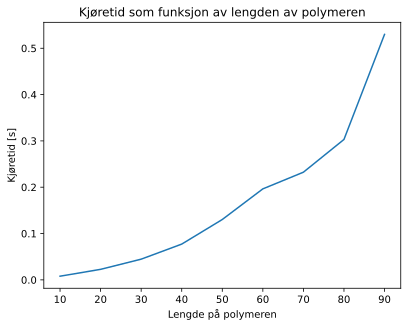

In [167]:
N_array = np.arange(10, 100, 10)
time_array = np.zeros(len(N_array))

for i in range(len(N_array)):
    start_time = time.perf_counter()
    random_rotations(init_polymer(N_array[i]), 1000)
    end_time = time.perf_counter() 
    total_time = end_time - start_time # Finding the difference in time
    time_array[i] = total_time

plt.plot(N_array, time_array)
plt.xlabel('Lengde på polymeren')
plt.ylabel('Kjøretid [s]')
plt.title('Kjøretid som funksjon av lengden av polymeren')
plt.show()

#### Prosentandel gyldige rotasjoner
Vi skal nå se på hvor stor prosentandelen gyldige rotasjoner av polymerer vi får utifra antall forsøkte simuleringer, $N_f$. Langs x-aksen har vi forskjellige lengder av polymeren. Vi observerer at ved en lav verdi for $N_f$ er prosentadnel gyldige rotasjoner ustabilt, men har et betydileg høyere gjennomsnitt enn de store $N_f$ verdiene. Dette kommer av at etter flere gyldige rotasjoner vil det bli mindre sannsynlighet for at neste rotasjon er mulig. Som sett tidligere vil en polymer med høy $N_f$ verdi generelt være mer foldet, og derfor ha vanskelighet for å rotere.

Ved høyere $N_f$ verdier vil prosentandelen gyldige rotasjoner minke betraktelig, men når $N_f$ blir høy nok blir grafene likere.

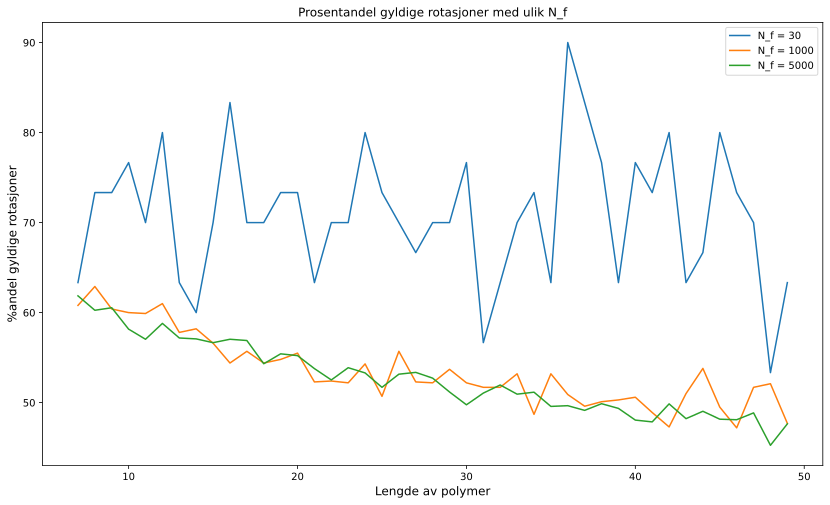

In [168]:
# Plot of different N_f values
n = 50 
N = np.arange(7,n) # Chooses the length of the polymer to be between 7 and 50

y_vals_30 = np.zeros(len(N))
y_vals_1000 = np.zeros(len(N))
y_vals_5000 = np.zeros(len(N))

for i in range(len(N)):
    y_vals_30[i] = ((random_rotations(init_polymer(N[i]), 30)[1])/30)*100
    y_vals_1000[i] = ((random_rotations(init_polymer(N[i]), 1000)[1])/1000)*100
    y_vals_5000[i] = ((random_rotations(init_polymer(N[i]), 5000)[1])/5000)*100

   
plt.figure(figsize=(14,8))
plt.plot(N, y_vals_30, label = 'N_f = 30')
plt.plot(N, y_vals_1000, label = 'N_f = 1000')
plt.plot(N, y_vals_5000, label = 'N_f = 5000')
plt.title('Prosentandel gyldige rotasjoner med ulik N_f')
plt.xlabel('Lengde av polymer', fontsize=12)
plt.ylabel('%andel gyldige rotasjoner', fontsize=12)
plt.legend(fontsize=10)
plt.show()

#### Energi
Dersom monomer m ender opp som nærmeste nabo med et monomer som ikke er monomer m-1 eller m+1, oppstår det svake vekselsvirkninger mellom monomerene. Dette kan skrives matematisk som:

$E = \frac{1}{2} \sum_{m,n} V_{mn} \cdot b_{mn}$

V er en NxN - matrise som inneholder styrken til vekselvirkningene. 


In [169]:
@njit
def make_V_const(N: int, const_value: float) -> np.ndarray:

    # Create a N x N matrix with constant values
    V = np.full((N, N), const_value)
    
    for i in range(N):
        for j in range(i-1, i+2):
            if 0 <= j < N:
                V[i, j] = 0 
    return V 


# Checks if one monomer is nearest neighbor to another monomer
@njit
def nearest_neighbor(x0: int, y0: int, x1: int, y1: int) -> bool:
    return (np.abs(x0 - x1) + np.abs(y0 - y1)) == 1

In [170]:
@njit
def calculate_energy(twisted_polymer: np.ndarray, V: np.ndarray) -> float: 

    # Assume that V[i, i+1] = V[i+1, i] = V[i, i] = 0 for all i

    energy = 0
    N = twisted_polymer.shape[0]
    for i in range(N):
        for j in range(0, i - 1):
            mon1 = twisted_polymer[i]
            mon2 = twisted_polymer[j]
            if nearest_neighbor(mon1[0], mon1[1], mon2[0], mon2[1]):
                energy += V[i, j] + V[j, i]

    return energy / 2.0

Vi bruker calculate_energy() for å regne ut energien til de to polymerene som er plottet over, en med 4 forsøkte rotasjoner og en med 1000 forsøkte rotasjoner.  

Resultatet vi får er at polymeren som er forsøkt rotert 4 ganger får en energi på -2.0, og energien til polymeren som er forsøkt rotert 1000 ganger får en energi på -5.0. I V-matrisen er alle de ikke 0-elementene konstant lik -1.0, dette gjør at monomerene får en tiltrekkende kraft mellom hverandre. Polymerene ønsker alltid å oppnå et energiminima, og ved denne V-matrisen vil energien minimeres ved at polymeren folder seg. Polymeren som er rotert 1000 ganger oppnår lavest energi, noe som stemmer med forventningene våres om at polymerene vil rotere seg til et energiminima.

In [171]:
print(f'Energien til polymeret som er forsøkt twisted 4 ganger er: {calculate_energy(polymer4, make_V_const(15, -1))}')
print(f'Energien til polymeret som er forsøkt twistet 1000 ganger er: {calculate_energy(polymer1000, make_V_const(15, -1))}')

Energien til polymeret som er forsøkt twisted 4 ganger er: 0.0
Energien til polymeret som er forsøkt twistet 1000 ganger er: -1.0


### Monte Carlo-steg
Vi har nå implementert funksjoner som ligger til grunn for all funksjonalitet av polymerene. Videre skal vi se på egenskapene under ulike omstendigheter, som temperatur og vekselvirkninger mellom monomerer. For å gjøre dette på best mulig måte bruker vi Monte Carlo-simulering for å generere pseudotilfeldige rotasjoner på et polymerer. Her definerer vi et Monte Carlo-steg som en gyldig rotasjon. Det vil si at rotasjoner som resulterer i en ødelagt polymer ikke telles som en simulasjon.

Under har vi definert simulate_energy() som returnerer energiverdier avhengig av antall rotasjoner $N_s$, vekselvirkningsmatrisen V og temperaturen T.

In [172]:
# Algorithm 2
@njit
def simulate_energy(polymer: np.ndarray, N_s: int, V: np.ndarray, T: int):
    E_array = np.zeros(N_s)
    E = calculate_energy(polymer, V)
    beta = 1 / (1.38e-23*T)

    i = 0
    while i < N_s:
        random_monomer = np.random.randint(1, len(polymer) - 1)  # Randomly choose a monomer
        twist_clockwise = np.random.rand() > 0.5  # Randomly choose the twist direction

        twisted_polymer = twist_polymer(polymer, random_monomer, twist_clockwise)
        if polymer_check(twisted_polymer, len(twisted_polymer)):
            i += 1
            E_new = calculate_energy(twisted_polymer, V)
            if E_new < E or np.random.rand() < np.exp(-beta * (E_new - E)):
                polymer = twisted_polymer
                E = E_new
            E_array[i] = E
        if i >= N_s - 1:
            break

    return polymer, E_array

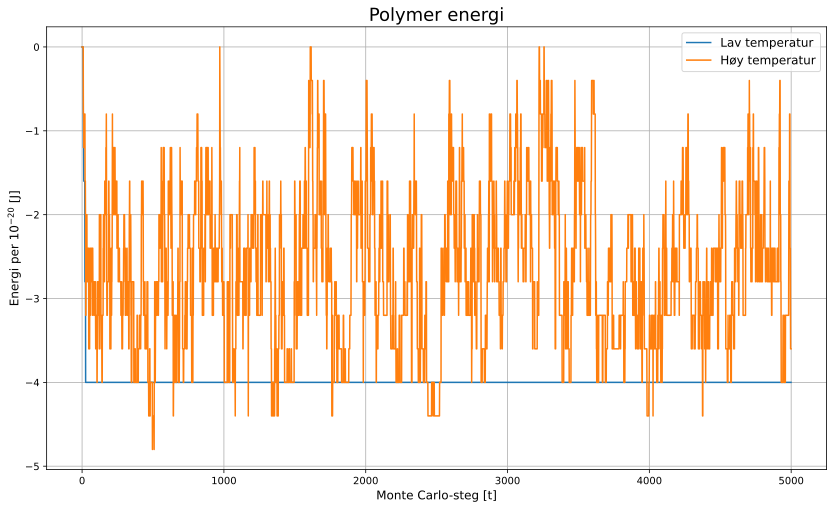

In [173]:
t = 5000 # Monte Carlo-steps
T_low = 70
T_high = 350

V_1 = make_V_const(20, -4.0e-21)
V_2 = make_V_const(20, -4.0e-21)

polymer1, energy_vals1 = simulate_energy(init_polymer(20), t, V_1, T_low) 
polymer2, energy_vals2 = simulate_energy(init_polymer(20), t, V_2, T_high) 

plt.figure(figsize=(14,8))
plt.title('Polymer energi', fontsize=18)
plt.xlabel('Monte Carlo-steg [t]', fontsize=12)
plt.ylabel('Energi per $10^{-20}$ [J]', fontsize=12) 
plt.grid()
plt.plot(np.arange(t), energy_vals1 * 1e20 , label = 'Lav temperatur')
plt.plot(np.arange(t), energy_vals2 * 1e20, label = 'Høy temperatur')
plt.legend(fontsize=12)
plt.show()

Grafene viser en tydelig forskjell mellom energien til et polymer med lav temperatur og et polymer med høy temperatur. Som nevnt vil en vilkårlig polymer prøve å ordne seg slik at den minimerer sin energi. Polymeren med lav temperatur holder et stabilt energinivå. Dette er fordi ved den lave temperaturen finner polymeren lett et lokalt energiminima, og har vanskelighet for å hoppe ut av denne energitilstanden til en annen. Ved den høye temperaturen ser vi at polymeren er svært ustabil ved at den stadig hopper mellom energinivå. Denne polymeren vil oppnå den laveste energitilstanden, altså det globale minima, men vil lett sprette ut av denne tilstanden.

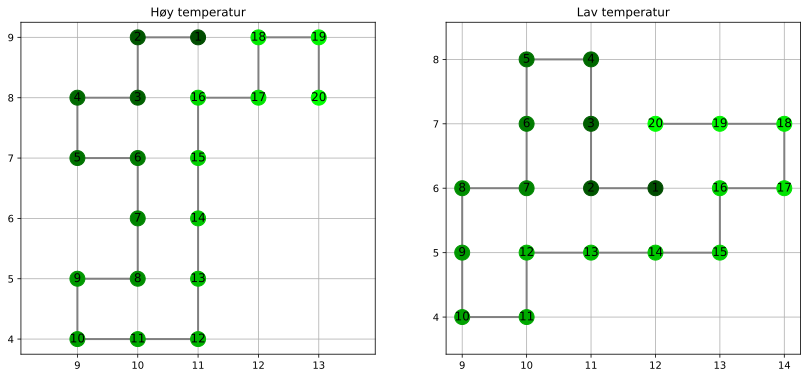

In [174]:
polymer_high_temp = polymer2
polymer_low_temp = polymer1

plot_two_polymers(polymer_high_temp, polymer_low_temp, t, t, 'Høy temperatur', 'Lav temperatur')

Her har vi plottet de to polymerene med lav og høy temperatur vedsiden av hverandre. For hver gang vi kjører koden ser vi at polymeren med høy temperatur vil ha større variasjoner i foldingene, dette er fordi den kan hoppe inn og ut av energiminima. Dette stemmer med det vi ser i grafen over. Den vil kunne strekke seg over ett større område enn polymeren med lav temperatur. Polymeren med lav temperatur vil ikke ha like store variasjoner i strukturen for hver gang koden blir kjørt. Dette er fordi under lave temperaturer vil polymeren låse seg fast i ett energiminima. Dette fører til at polymeren ender opp i en mer foldet sluttposisjon den ikke klarer å rotere seg ut av. 

#### Vekselvirkningsmatrisen sin påvirkning på sluttresultatet til polymeren
Vi skal nå eksperimentere med matrisen V for å oppnå kule strukturer på polymerene, som sirkel- og sikksakkmønster. Derfor er det viktig å forstå hvordan matrisen V påvirker de tilfeldige rotasjonene. V beskriver styrken til vekselvirkningene mellom alle monomerene. Dermed vil alltid diagonalen, underdiagonalen og overdiagonalen være 0 siden det ikke er vekselvirkninger mellom monomer m og m-1/m+1. V er også alltid symmetrisk da vekselvirkningene mellom to monomerer skal gå begge veier og være like store.

I make_V_circle() ønsker vi å øke sjansen for å ende med et polymer formet som en sirkel. Vi vil at endemonomerene skal tiltrekkes hverandre og at resten av monomerene skal frastøte hverandre. For å få til dette ga vi de tre ytterste monomerene, ikke kun endenemonomerene, tiltrekning. Dette vil øke sannsynligheten for at polymeren ender som en sirkel. I matrisen V har vi gitt de 9 elementene nederst i venstre hjørne en negativ verdi, tiltrekning, da hver av disse representerer vekselvirkningen mellom monomer 1, 2 og 3 med monomer N, N-1 og N-2. Resten av elementene i matrisen har vi gitt en positiv verdi, frastøtning, for så å speile elementene under diagonalen. Siden polymeren ønsker å minimere energien sin vil den at endene skal finne sammen og at resten av monomerene ikke skal være nærmeste nabo med noen andre monomerer. Vi har valgt såpasss stor tiltrekning at når endene først finner sammen er det veldig liten sannsynlighet for at de går fra hverandre igjen. Dette krever i så fall høy temperatur. Sirkelen vil ikke alltid være like fin, som følger av at vekselvirkningene kun virker mellom nærmeste naboer. Likevel, vil vi med stor sannsynlighet få en lukket polymer med hulrom i midten.

I make_V_folded() ønsker vi å lage et sikksakk mønster. For å oppnå dette gir vi hvert tredje monomer tiltrekning og resten frastøtning, som vil skape et mønster. På samme måte som i sirkelen simuleres det tilfeldige rotasjoner, frem til monomerene finner sammen med andre med tiltrekning. Dermed vil polymeren beholde denne posisjonen, da det krever mye energi å bryte ut av den nye strukturen og polymeren helst ønsker å minimere energien. Det er ikke sikkert at det blir et perfekt sikk sakk mønster, men definitivt større sannsynlinghet enn ved en V matrise med identiske elementer. Denne funksjonen baserer seg på polymerets ønske om å minimere energien sin, som skjer ved tiltrekningene.

In [175]:
# V-matrix that generates a circle
@njit
def make_V_circle(N: int, binding_energy=4e-21) -> np.ndarray:
    # Attraction of the three first and three last monomers and repulsion of other monomers
  
    V = np.full((N, N), 5 * binding_energy)

    for i in range(N):
        for j in range(N):
            if np.abs(i - j) <= 1:
                V[i, j] = 0.0
    
    V[N-3:N, :3] = V[:3, N-3:N] = -100 * binding_energy
    
    return V 

# V-matrix that generates a zig-zag pattern
@njit
def make_V_folded(N: int, binding_energy=4e-21) -> np.ndarray:
    # Every third monomer is attracted to the monomer 6 indices ahead

    V = np.full((N, N), binding_energy)
    binding_energy *= 10

    for i in range(N):
        if i % 6 == 0 and i + 5 < N:
            V[i, i + 5] = V[i + 5, i] = -binding_energy
        elif i % 6 == 1 and i + 3 < N:
            V[i, i + 3] = V[i + 3, i] = -binding_energy
        elif i % 6 == 3 and i + 5 < N:
            V[i, i + 5] = V[i + 5, i] = -binding_energy
        elif i % 6 == 4 and i + 3 < N:
            V[i, i + 3] = V[i + 3, i] = -binding_energy
    
    for i in range(N):
        for j in range(N):
            if np.abs(i - j) <= 1:
                V[i, j] = 0.0

    return V

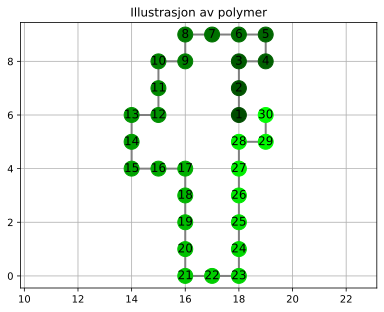

In [176]:
N = 30 # Setting the polymer length

# Plot of circle shaped polymer:
polymerS = simulate_energy(polymer=init_polymer(N), N_s=100_000, V=make_V_circle(N), T=350)[0]
plot_polymer(polymerS)

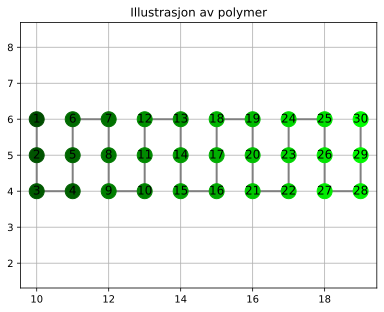

In [177]:
# Plot of zig-zag shaped polymer:
polymerZ = simulate_energy(polymer=init_polymer(N), N_s=100_000, V=make_V_folded(N), T=350)[0]
plot_polymer(polymerZ)

Videre skal vi se på forventet energi og største Euklidske avstand til polymerer. Under simulerer vi forventningsverdien og standardavviket til energien ved ulike temperaturer, for så å plotte disse verdiene.

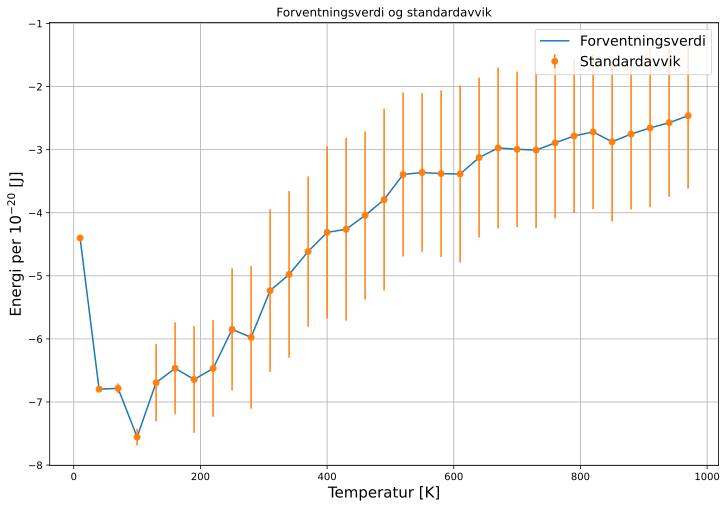

In [178]:
N_p = 30
N_s = 10_000
V = make_V_const(N_p, -4e-21)
T = np.arange(start=10, stop=1000, step=30)

E_array_mean = np.zeros(len(T)) 
E_array_sd = np.zeros(len(T))

polymer0 = init_polymer(N_p)

for i in range(len(T)):
    _polymer, E_array = simulate_energy(polymer0, N_s, V, T[i]) # Simulates energy values

    # Excluding the first 1000 simulation steps
    E_array_mean[i] = np.mean(E_array[1000:])  # Calculates mean value of energy
    E_array_sd[i] = np.std(E_array[1000:]) # Calculates standard deviation of the energy values

plt.figure(figsize=(12,8))
plt.plot(T, E_array_mean *1e20 , label='Forventningsverdi')
plt.errorbar(T, E_array_mean *1e20, yerr=E_array_sd *1e20, fmt='o', label='Standardavvik')
plt.legend(fontsize=14)
plt.title('Forventningsverdi og standardavvik')
plt.xlabel('Temperatur [K]', fontsize=15)
plt.ylabel('Energi per $10^{-20}$ [J]', fontsize=15)
plt.grid()
plt.show()

Grafen forteller oss at ved lav temperatur er forventet energi lav. Vi observerer også at standardavvikket ved de laveste temperaturene er lite. Dette skyldes fenomenet vi så i forrige energigraf, der polymeren hadde lett for å låse seg fast i et lokalt energiminima ved lav temperatur. Ved låsing av polymeren vil energien holde seg konstant, og derav får vi et svært lite standardaavik for forventet energi. Vi ser at når temperaturen overstiger rundt 200 Kelvin og går mot varmere temperaturer, stiger forventet energi mye og standardavvikene blir store. Dette stemmer overens med observasjonen vår om at en polymer ved høy temperatur er energimessig kaotisk og hopper stadig mellom energinivå. Ved høy temperatur er det altså uforventet hvilken energi polymeren får og denne uforutsigbarheten gir oss det høye standardavviket.

Vi har testet forskjellige verdier av $N_s$, og ser at grafen blir glattere ved økning av $N_s$. Dette kommer av at forventningsverdien ved en lav $N_s$ vil være mer preget av tilfeldigheter enn en med høy $N_s$, som resulterer i den ujevne grafen.

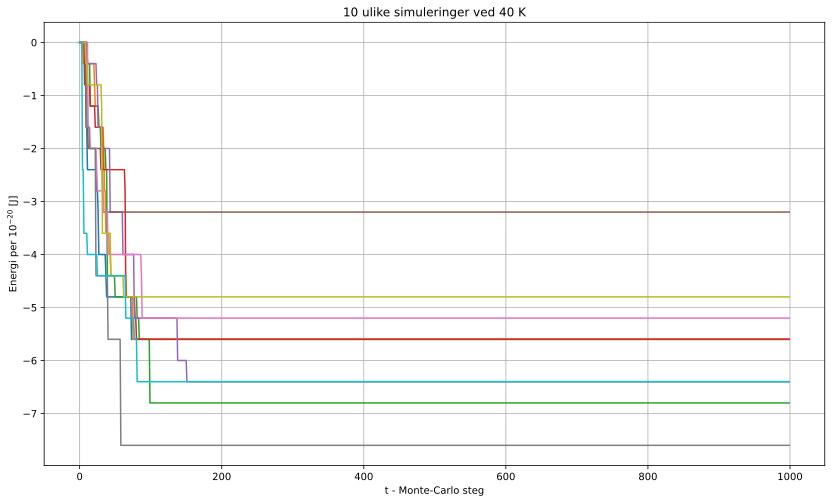

In [181]:
T = 40
t = 1000
x_vals = np.arange(t)
plt.figure(figsize=(14, 8))

for _ in range(10):
    E_array = simulate_energy(init_polymer(N), t, V, T)[1] # Simulates energy values
    plt.plot(x_vals, E_array *1e20)

plt.title(f'10 ulike simuleringer ved {T} K')
plt.xlabel('t - Monte-Carlo steg')
plt.ylabel('Energi per $10^{-20}$ [J]')
plt.grid()
plt.show()

De 10 simuleringene ved samme lave temperatur bekrefter det vi har sett tidligere. Alle polymerene finner tidlig et lokalt energiminima og klarer ikke hoppe ut av det, derav stabiliserer grafene seg. Ved å kjøre de 10 simuleringeringene og plotte de i samme graf kan man enklere anslå energien til en kald polymer ved å se på hvilket energiintervall grafene er stabile ved.

In [182]:
@njit
def make_V_random(N: int) -> np.ndarray:

    V = np.full((N, N), 0.0)

    for i in range(N):
        for j in range(0, i - 1):
                V[i, j] = V[j, i] = np.random.uniform(-6e-21, -2e-21) # Choosing a random number between -6e-21 and -2e-21

    return V

For å finne den største Euklidiske avstanden mellom to monomerer i polymeren brukte vi en dobbeltløkke der vi regner ut avstanden fra en monomer til alle de etterfølgende monomerene ved hjelp av pythagoras. Legg merke til at ved denne metoden sjekker vi ikke samme avstand to ganger, noe som er bra for kjøretiden. Å ta kvadratrot er en kjøretidsmessig kostbar operasjon, så vi velger derfor å først finne maksimum distanse og ta kvadratroten helt til slutt.

In [183]:
@njit
def max_euclidean_distance(polymer: np.ndarray) -> float:
    N = len(polymer)

    # Find maximum distance^2 between two monomers
    max_dist2 = 0.0
    for i in range(N):
        for j in range(i+1, N):
            max_dist2 = max(max_dist2, (polymer[i][0] - polymer[j][0]) ** 2 + (polymer[i][1] - polymer[j][1]) ** 2) # Updates the maximum distance
    # Take the square root of maximum distance^2
    return np.sqrt(max_dist2)

For å kunne bruke diameteren i de resterende oppgavene må vi implementere den i algoritme 2, som er gjort under.

In [184]:
# Algorithm 2 with diameter:
@njit
def simulate_energy_with_diameter(polymer, N_s, V, T: np.ndarray):
    E_array = np.zeros(N_s)
    d_array = np.zeros(N_s)
    E = calculate_energy(polymer, V)
    beta = 1 / (1.38e-23*T)

    i = 0 
    while i < N_s:
        random_monomer = np.random.randint(0, len(polymer))  # Randomly choose a monomer
        twist_clockwise = np.random.rand() < 0.5  # Randomly choose the twist direction

        twisted_polymer = twist_polymer(polymer, random_monomer, twist_clockwise)
        if polymer_check(twisted_polymer, len(twisted_polymer)):
            E_new = calculate_energy(twisted_polymer, V)
            if E_new < E or np.random.rand() < np.exp(-beta * (E_new - E)):
                polymer = twisted_polymer
                E = E_new
            E_array[i] = E
            d_array[i] = max_euclidean_distance(polymer) # Finding max Euclidean distance values
            i += 1
        if i >= N_s - 1:
            break

    return polymer, E_array, d_array

Vi har testet ulike verdier for $N_s$ og sett at grafen blir jevnere jo høyere $N_s$ er. Koden vår kjører kjapt, men vi konkluderte med at med $N_s$ = 100 000 gir oss en veldig jevn graf, uten at kjøretiden blir for lang. Den bruker omtrent 5 minutter.

In [186]:
start = time.perf_counter()

N = 30
N_s = 10_000

V = make_V_random(N)
T = np.arange(10, 1000, 30)
d_array_mean_diff_temp = np.zeros(len(T))

initial_polymer = init_polymer(N)

for i in range(len(T)):
    _polymer, _E_array, d_array = simulate_energy_with_diameter(init_polymer(N), N_s, V, T[i])
    # Excluding the first 1000 simulation steps
    d_array_mean_diff_temp[i] = np.mean(d_array[1000:])

end = time.perf_counter()
total = np.round(end - start, 3)
print(f'Funksjonen tok {total} sek')

Funksjonen tok 31.991 sek


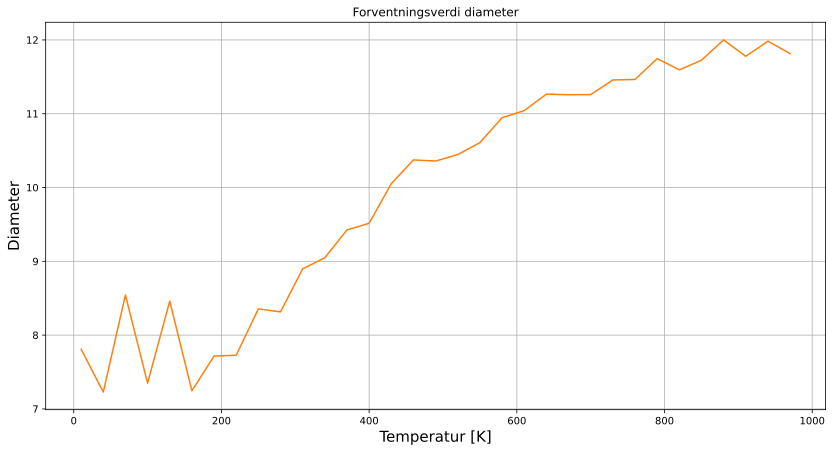

In [187]:
plt.figure(figsize=(14,7))
plt.plot(T, d_array_mean_diff_temp, label='Forventningsverdi', color='C1')
plt.title('Forventningsverdi diameter')
plt.xlabel('Temperatur [K]', fontsize=15)
plt.ylabel('Diameter', fontsize=15)
plt.grid()
plt.show()

Ut ifra grafen kan vi se at den forventede største Euklidiske avstanden $\langle d \rangle$ øker i samsvar med temperaturen. Det vil si den største avstanden mellom to monomerer øker med energien til polymeren.

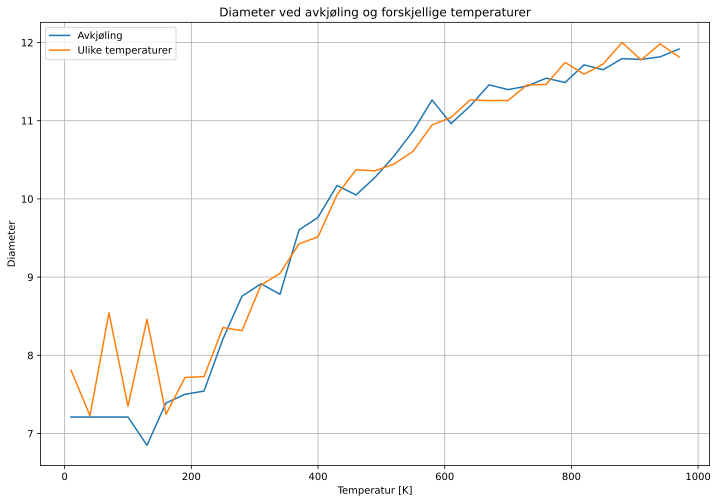

In [188]:
T_rev = T[::-1]

d_array_mean_cooling = np.zeros(len(T_rev))
running_polymer = init_polymer(N)
for i in range(len(T_rev)):
    # Reuse polymer
    running_polymer, _E_array, d_array = simulate_energy_with_diameter(running_polymer, N_s, V, T_rev[i])
    d_array_mean_cooling[i] = np.mean(d_array[1000:])

plt.figure(figsize=(12,8))
plt.title('Diameter ved avkjøling og forskjellige temperaturer')
plt.xlabel('Temperatur [K]')
plt.ylabel('Diameter')
plt.plot(T, d_array_mean_cooling[::-1], label = 'Avkjøling')
plt.plot(T, d_array_mean_diff_temp, label = 'Ulike temperaturer')
plt.legend(fontsize=10)
plt.grid()
plt.show()

Ved avkjøling av polymeren vil den gjennomgå en frysning. Dette ses på avkjøingsgrafen fra rundt 100 Kelvin og ned til 0 Kelvin, der diameteren holdes konstant. Grunnen til dette er at polymeren har foldet seg sammen og låst seg i et energiminima. Startpolymeren er her en horisontal polymer og for hvert temperatursteg beholder vi sluttilstanden til den forrige polymeren og bruker den som starttilstanden i neste simulasjon. 

Ved å sammenligne diameteren av en polymer under avkjøling med diameteren til en polymer ved ulike konstante temperaturer ser vi at ved høye temperaturer oppfører diameteren til polymeren seg likt. Ved lave temperaturer, ser vi at polymeren under avkjøling vil ende opp med en konstant liten diameter. Siden den andre grafen starer med en ny polymer for hver temperatur, blir det mer variasjon i diameteren og grafen oppnår ikke denne konstante lave diameteren.

For å se på oppførselen til et polymer ved høye temperaturer kan vi bruke begge metodenene. Ved lave temperaturer, derimot, vil en frysning av polymeren gi best grunnlag for å analysere egenskapene. Dette er grunnet i at en polymer i realiteten ikke kan hoppe mellom temperaturer, men må gradvis avkjøles.

Her er en illustrasjon av sluttpolymeret ved avkjøling, altså det fryste polymeret ved 0 Kelvin. Denne er helt sammenfoldet, noe som forklarer den lave diameteravstanden. Polymeren har oppnådd et lokalt energiminima og vil holde seg i denne tilstanden.

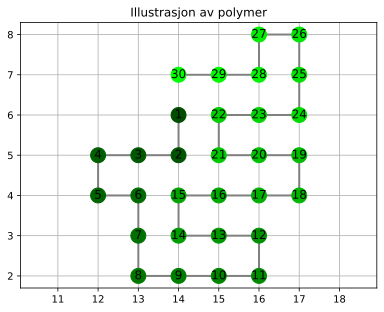

In [189]:
plot_polymer(running_polymer)

#### Avslutning
Monte Carlo-simulering har vært et bra verktøy for å kunne analysere oppførselen til polymerer under forskjellige omstendigheter. Vi har generert ulike plott som stemmer overens med forventede resultater. Det er tydlig at antall rotasjoner, temperatur og styrke på vekselvirkningene har hatt stor innvirkning på både energi og største Euklidske avstand i et polymer. 

Arbeidet vårt viser hvordan to ulike naturvitenskaplige grener møtes og forklarer hverandre, biologien og matematikken. Etter alt dette arbeidet befinner vi oss i et energiminima, forhåpentligvis et lokalt et, som vi lett kan hoppe ut av om snøen snart smelter her i Trondheim!

#### Referanseliste
- Anaconda, Inc. m. flere. A ~5 minute guide to Numba. Numba. Hentet fra: https://numba.readthedocs.io/en/stable/user/5minguide.html [27.01.2024]
- Steele, P. (2015). Making Python Fast. *Cornell University*. Hentet fra: https://people.orie.cornell.edu/prs233/orie-6125/speed/speed.html [30.01.2024]